In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta as td
import os #Для получения списка файлов и определения самого последнего из них по названию

today = dt.now();
current_date = str(dt.now())[:10];

'Целевые переменные'

,Приток_IRK,Приток_SHA,Приток_KRA,Приток_BRA,Приток_UIM,Приток_BOG,Сброс_IRK,Сброс_SHA,Сброс_KRA,Сброс_BRA,Сброс_UIM,Сброс_BOG,Уровень_IRK,Уровень_SHA,Уровень_KRA,Уровень_BRA,Уровень_UIM,Уровень_BOG
Дата,,,,,,,,,,,,,,,,,,
2021-12-01,-158.333333,515.161290,1547.391304,2619.666667,5479.133333,3431.129032,2281.333333,1210.290323,3581.304348,5479.133333,3391.966667,3702.548387,456.80,527.55,234.66,401.37,295.66,207.48
2022-01-01,539.285714,457.741935,1499.032258,2271.935484,3928.064516,3641.096774,2032.903226,1209.677419,2416.129032,3928.064516,3714.516129,3538.709677,456.67,522.81,233.07,400.38,295.81,207.62
2022-02-01,530.357143,418.928571,1385.714286,1726.964286,3327.500000,3830.142857,1539.285714,1153.571429,2311.428571,3327.500000,3792.500000,3980.357143,456.59,517.20,231.62,399.55,295.40,207.54
2022-03-01,359.354839,408.709677,2205.483871,2235.967742,3222.709677,3640.645161,2056.612903,1457.129032,2314.838710,3222.709677,3528.548387,3834.838710,456.49,508.39,230.83,399.17,294.88,207.18
2022-04-01,1120.000000,665.200000,2548.695652,3010.800000,3215.480000,3569.000000,2436.400000,1415.960000,2223.913043,3215.480000,3543.400000,3686.920000,456.38,500.27,231.16,399.36,294.57,207.04


'Осадки условный факт'

,Sec_1,Sec_4,Sec_7,Sec_2,Sec_5,Sec_8,Sec_3,Sec_6,Sec_9
Дата,,,,,,,,,
2011-10-01,1.589989,2.810485,3.051070,1.073116,1.943756,2.581865,0.855280,1.441800,2.390435
2011-11-01,1.238201,2.198404,2.145847,0.656810,1.368867,1.635725,0.579954,0.792982,1.301832
2011-12-01,0.744035,1.558141,1.621923,0.443884,1.008537,1.179551,0.380857,0.483756,0.904007
2012-01-01,0.639773,1.195637,1.119042,0.339066,0.738717,0.780387,0.264979,0.347111,0.559780
2012-02-01,0.767590,1.073633,0.947410,0.472043,0.690080,0.724587,0.410856,0.404389,0.607161


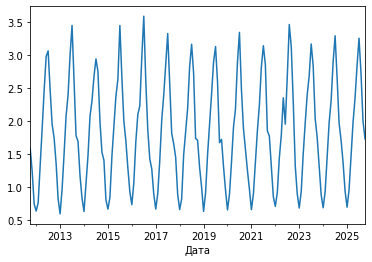

In [2]:
#Соханим словарь названий ГЭС, чтобы в дальнейшем было нагляднее где какая ГЭС
GES_name = {'IRK': 'Иркутская ГЭС', 'SHA': 'Саяно-Шушенская ГЭС', 'KRA': 'Красноярская ГЭС',
            'BRA': 'Братская ГЭС', 'UIM': 'Усть-Илимская ГЭС', 'BOG': 'Богучанская ГЭС'};

#Узнаем дату с последним сохранением модели CatBoost
date_data_model = max([i[:10] for i in os.listdir('../data/Исходные данные/Показатели ГЭС/Свод после обработки/') if 'Графики' not in i]);

#Загрузим данные
target = pd.read_excel(f'../data/Исходные данные/Показатели ГЭС/Свод после обработки/{date_data_model} Целевые переменные.xlsx', index_col=0, header=0); #Притоки, сбросы, уровни
target.index = pd.to_datetime(target.index.astype(str), yearfirst=True); #При загрузке данные у индекса не самый удобный тип данных - поменяем
ml_forecast = pd.read_excel(f'../data/Исходные данные/Данные с сайта IRI/{date_data_model} IRI прогноз + Prophet.xlsx', index_col=0, header=0); #Осадки по прогнозной модели IRI + Prophet

GES_pritok = [i for i in target.columns if 'Приток' in i];
GES_sbros = [i for i in target.columns if 'Сброс' in i];
GES_uroven = [i for i in target.columns if 'Уровень' in i];
GES = GES_sbros+GES_pritok+GES_uroven;
pre_GES = ['Был_' + i for i in GES];

display('Целевые переменные', target.tail(), 'Осадки условный факт', ml_forecast.head());
ml_forecast['Sec_1'].plot();

# Этап 1

Балансовый метод

Научимся определять уровень воды по объёму в водохранилище.

In [3]:
#Получим данные по взаимосвязанности Уровень-Объем
interpol_uroven = pd.read_excel('../data/Исходные данные/Показатели ГЭС/объем ВДХР.xlsx', header=0);

#Определим функцию зависимости
f_o_ot_y = {}; #функция полинома объём от уровня
f_y_ot_o = {}; #функция полинома уровня от объёма
for ges in GES_name:
    params = np.polyfit(interpol_uroven.loc[interpol_uroven['ГЭС']==GES_name[ges], 'Уровень, м'],
                        interpol_uroven.loc[interpol_uroven['ГЭС']==GES_name[ges], 'Объем, км3'], 2);
    f_o_ot_y[ges] = np.poly1d(params);
    
    params = np.polyfit(interpol_uroven.loc[interpol_uroven['ГЭС']==GES_name[ges], 'Объем, км3'],
                        interpol_uroven.loc[interpol_uroven['ГЭС']==GES_name[ges], 'Уровень, м'], 2);
    f_y_ot_o[ges] = np.poly1d(params);
    print(GES_name[ges], '\nУровень-объём\n', f_y_ot_o[ges], '\nОбъём-уровень\n', f_o_ot_y[ges], '\n\n');

Иркутская ГЭС 
Уровень-объём
            2
2.163e-07 x + 0.03172 x + 455 
Объём-уровень
            2
-0.006754 x + 37.67 x - 1.574e+04 


Саяно-Шушенская ГЭС 
Уровень-объём
           2
-0.09059 x + 6.858 x + 413.6 
Объём-уровень
           2
0.004749 x - 4.566 x + 1112 


Красноярская ГЭС 
Уровень-объём
            2
-0.003341 x + 0.9866 x + 188.7 
Объём-уровень
          2
0.01656 x - 6.057 x + 567.2 


Братская ГЭС 
Уровень-объём
             2
-0.0005883 x + 0.3801 x + 354.3 
Объём-уровень
          2
0.06422 x - 46.13 x + 8337 


Усть-Илимская ГЭС 
Уровень-объём
            2
-0.004219 x + 1.03 x + 249.9 
Объём-уровень
          2
0.01866 x - 9.204 x + 1148 


Богучанская ГЭС 
Уровень-объём
           2
-0.01664 x + 1.823 x + 155.8 
Объём-уровень
          2
0.02084 x - 6.52 x + 512.1 




In [4]:
#Добавим дополнительные фичи и целевую переменную
df_balance = pd.concat([ml_forecast,
                        ml_forecast.rolling(4, min_periods=0).mean().add_prefix('Среднее_'),
                        target.shift(1).add_prefix('Был_'), 
                        target.loc[:, GES]
                       ], axis=1).loc[ml_forecast.index];

df_balance.insert(0, 'month', df_balance.index.month.astype(float)); #Тип данных нужно указать для нормализации
df_balance.insert(1, 'weekofyear', pd.Int64Index(df_balance.index.isocalendar().week).astype(float)); #Тип данных нужно указать для нормализации

df_balance

,month,weekofyear,Sec_1,Sec_4,Sec_7,Sec_2,Sec_5,Sec_8,Sec_3,Sec_6,...,Приток_KRA,Приток_BRA,Приток_UIM,Приток_BOG,Уровень_IRK,Уровень_SHA,Уровень_KRA,Уровень_BRA,Уровень_UIM,Уровень_BOG
Дата,,,,,,,,,,,,,,,,,,,,,
2011-10-01,10.0,39.0,1.589989,2.810485,3.051070,1.073116,1.943756,2.581865,0.855280,1.441800,...,2240.0,2250.0,2974.0,2967.0,456.70,535.89,236.99,398.26,295.74,192.78
2011-11-01,11.0,44.0,1.238201,2.198404,2.145847,0.656810,1.368867,1.635725,0.579954,0.792982,...,1970.0,1870.0,2922.0,2968.0,456.55,532.81,235.15,397.73,295.75,192.78
2011-12-01,12.0,48.0,0.744035,1.558141,1.621923,0.443884,1.008537,1.179551,0.380857,0.483756,...,1785.0,1760.0,2816.0,2814.0,456.39,529.17,233.15,397.28,295.68,192.78
2012-01-01,1.0,52.0,0.639773,1.195637,1.119042,0.339066,0.738717,0.780387,0.264979,0.347111,...,1740.0,1710.0,2933.0,2908.0,456.29,524.44,231.49,396.75,295.84,192.78
2012-02-01,2.0,5.0,0.767590,1.073633,0.947410,0.472043,0.690080,0.724587,0.410856,0.404389,...,1705.0,1670.0,2646.0,2851.0,456.20,516.59,230.26,396.35,295.50,192.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01,6.0,22.0,2.837256,3.167681,2.635748,2.856851,2.449110,2.045651,2.236598,3.322835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-01,7.0,27.0,3.260708,3.163826,2.190841,3.863759,2.812458,1.709593,3.220664,3.889977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-01,8.0,31.0,2.727090,2.921780,2.103437,3.316328,2.546008,1.591504,2.939874,3.538151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Этап 2

Прогноз CatBoost'ом и Балансовый метод

In [5]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

In [6]:
#Итерационно выполним прогноз выработки ГЭС
#По осадкам и показателям прошлого месяца спрогнозируем приток
#По показателям прошлого месяца и притоку спрогнозируем сброс
#Балансовым методом рассчитаем уровень водохранилища, который установится в бассейне водохранилища

CatBoost_pritok = {}; #Коэффициенты модели притока
CatBoost_sbros = {}; #Коэффициенты модели сброса
CatBoost_uroven = {}; #Коэффициенты модели уровня

#Узнаем дату с последним сохранением файлов после выполнение блокнота №2
max_date_catboost_pritok = max([i[:10] for i in os.listdir('../data/Параметры модели/coef CatBoost приток/')]);
max_date_catboost_sbros = max([i[:10] for i in os.listdir('../data/Параметры модели/coef CatBoost сброс/')]);
max_date_catboost_uroven = max([i[:10] for i in os.listdir('../data/Параметры модели/coef CatBoost уровень/')]);
max_date_scaler = max([i[:10] for i in os.listdir('../data/Параметры модели/StandardScaler fit/')]);

#Загрузим коэффициенты CatBoost
for col in GES_name:
    CatBoost_pritok[col] = CatBoostRegressor().load_model(f'../data/Параметры модели/coef CatBoost приток/{max_date_catboost_pritok} Модель для Приток_{col}.cbm');
    CatBoost_sbros[col] = CatBoostRegressor().load_model(f'../data/Параметры модели/coef CatBoost сброс/{max_date_catboost_sbros} Модель для Сброс_{col}.cbm');
    CatBoost_uroven[col] = CatBoostRegressor().load_model(f'../data/Параметры модели/coef CatBoost уровень/{max_date_catboost_uroven} Модель для Уровень_{col}.cbm');

sc = StandardScaler();
#Загрузим коэффициенты стандартизации данных
scaler_pritok = joblib.load(f'../data/Параметры модели/StandardScaler fit/{max_date_scaler} Приток Стандартизация данных.joblib');
scaler_sbros = joblib.load(f'../data/Параметры модели/StandardScaler fit/{max_date_scaler} Сброс Стандартизация данных.joblib');
scaler_uroven = joblib.load(f'../data/Параметры модели/StandardScaler fit/{max_date_scaler} Уровень Стандартизация данных.joblib');
coun = min(df_balance.loc[df_balance.isna().any(1)].index);
for mes in df_balance.loc[df_balance.isna().any(1)].index:
    pre_mes = mes - td((mes - td(1)).day); #Получи дату предыдущего месяца
    df_balance.loc[mes, pre_GES] = df_balance.loc[pre_mes, GES].values; #Запишем в качестве данных "Было_" показатели предыдущего месяца
    
    #Прогноз притока
    for col in GES_name:
        srez_pritok = df_balance.loc[mes, CatBoost_pritok[col].feature_names_]; #Сформируем данные
        if srez_pritok.isna().any():
            print(f'При прогнозе притока по дате {str(mes)[:10]} есть Nan. Нужно исправить ошибку в коде');
            break
        dan_pritok = scaler_pritok.transform(srez_pritok.values.reshape(1,-1)); #Нормализуем данные
        df_balance.loc[mes, 'Приток_'+col] = CatBoost_pritok[col].predict(dan_pritok); #Прогноз
    
    #Прогноз сброса
    for col in GES_name:   
        srez_sbros = df_balance.loc[mes, CatBoost_sbros[col].feature_names_]; #Сформируем данные
        if srez_sbros.isna().any():
            print(f'При прогнозе сброса по дате {str(mes)[:10]} есть Nan. Нужно исправить ошибку в коде');
            break
        dan_sbros = scaler_sbros.transform(srez_sbros.values.reshape(1,-1)); #Нормализуем данные
        df_balance.loc[mes, 'Сброс_'+col] = CatBoost_sbros[col].predict(dan_sbros); #Прогноз
        
    #Экспертно
    df_balance.loc[mes, 'Приток_UIM'] = df_balance.loc[mes, 'Сброс_BRA'];
    
    #Прогноз уровня
    for col in GES_name:   
        srez_uroven = df_balance.loc[mes, CatBoost_uroven[col].feature_names_]; #Сформируем данные
        if srez_uroven.isna().any():
            print(f'При прогнозе уровня по дате {str(mes)[:10]} есть Nan. Нужно исправить ошибку в коде');
            break
        dan_uroven = scaler_uroven.transform(srez_uroven.values.reshape(1,-1)); #Нормализуем данные
        df_balance.loc[mes, 'Уровень_'+col] = CatBoost_uroven[col].predict(dan_uroven); #Прогноз        
          
    if srez_pritok.isna().any() or srez_sbros.isna().any() or srez_uroven.isna().any():
        print('Nan в фрейме')
        break
    
    #Прогноз уровня  баланосым методом
    for col in GES_name:
        if mes == coun:
             df_balance.loc[pre_mes, 'Баланс_Уровень_'+col] = df_balance.loc[pre_mes, 'Уровень_'+col];
        v_before = f_o_ot_y[col](df_balance.loc[pre_mes, 'Баланс_Уровень_'+col]); #Переводим исходный уровень в объём
        v_delta = (df_balance.loc[mes, 'Приток_'+col]-df_balance.loc[mes, 'Сброс_'+col])*60*60*24*mes.days_in_month/10**9; #Ризница приток-объём это изменение в водохранилище
        v_now = v_before + v_delta; #Новый объём
        df_balance.loc[mes, 'Баланс_Уровень_'+col] =  f_y_ot_o[col](v_before + v_delta); #Новый уровень

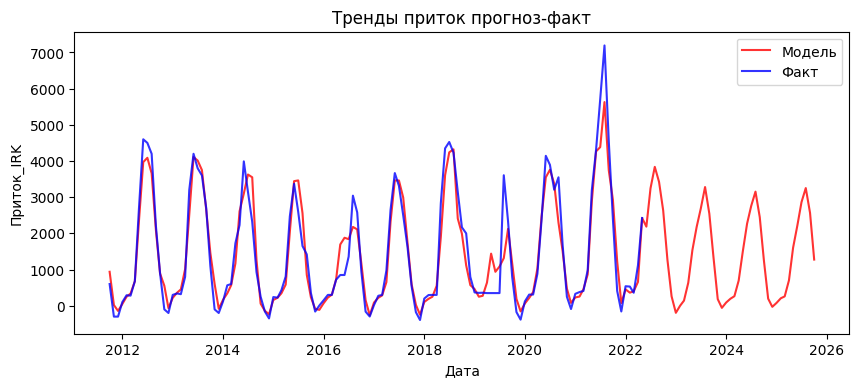

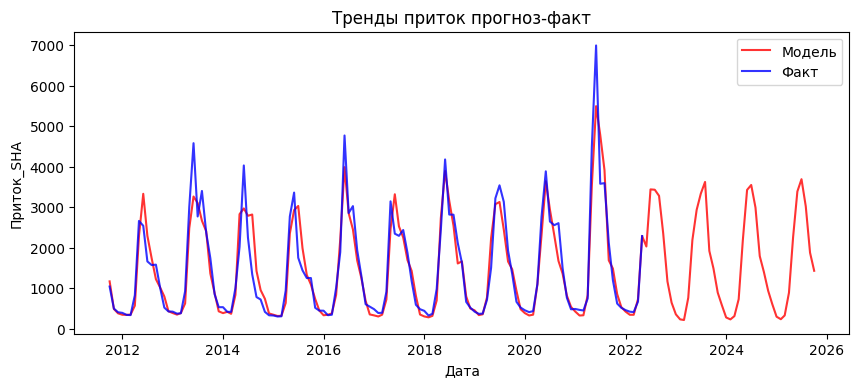

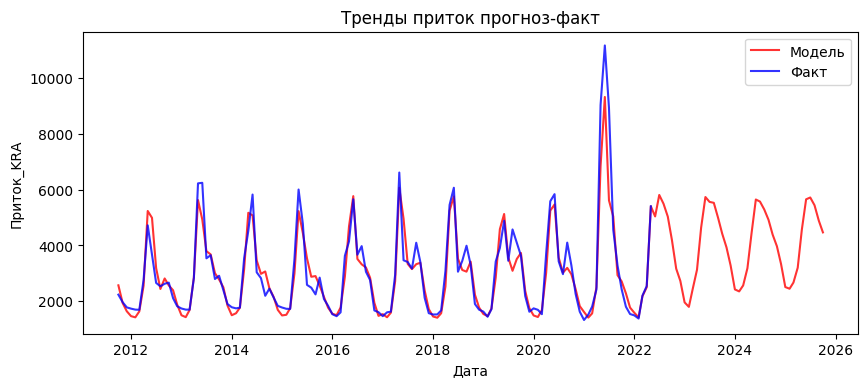

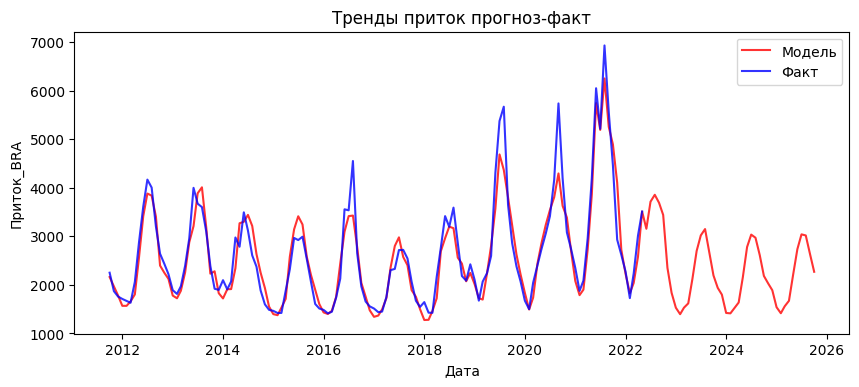

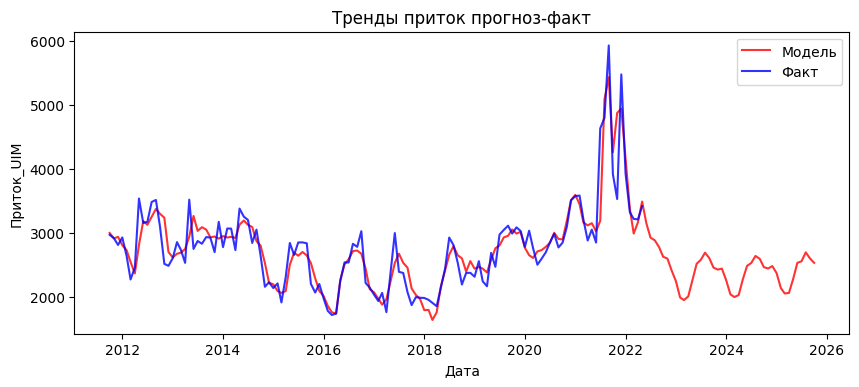

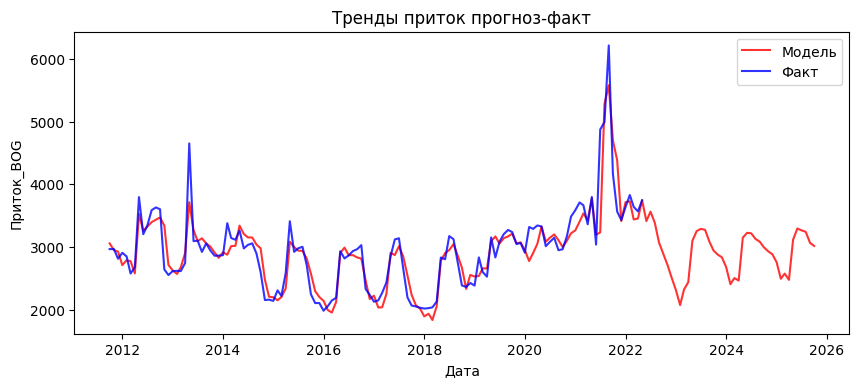

In [7]:
for col in GES_name:
    plt.subplots(figsize=(10,4), dpi=100);
    sns.lineplot(y=CatBoost_pritok[col].predict(scaler_pritok.transform(df_balance.loc[:, CatBoost_pritok[col].feature_names_])), x=df_balance.index,
                 label='Модель', color='Red', alpha=0.8);
    sns.lineplot(y=df_balance.loc[:coun, 'Приток_'+col], x=df_balance.loc[:coun].index,
                 label='Факт', color='Blue', alpha=0.8);
    plt.title('Тренды приток прогноз-факт');
    plt.savefig(f'../data/Результаты моделирования/Приток прогноз/{current_date} Модель для {col}.png', dpi=200);
    plt.show();

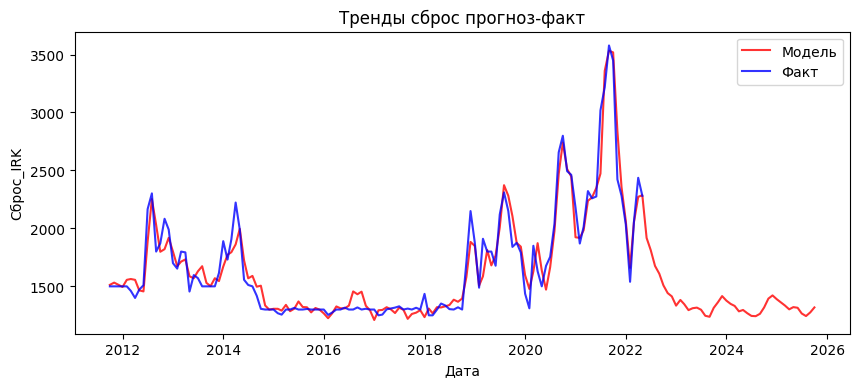

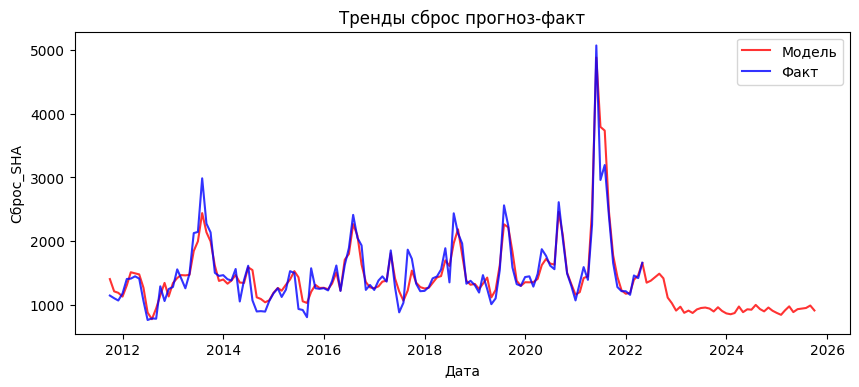

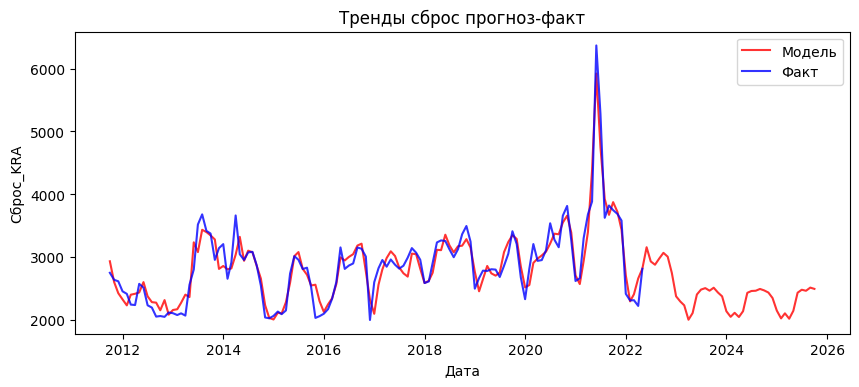

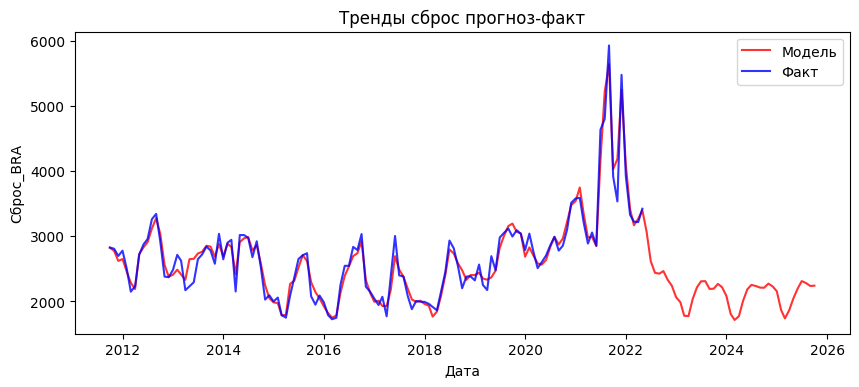

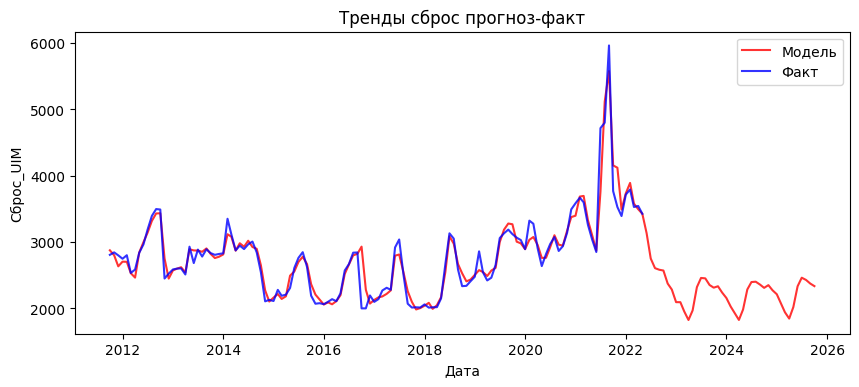

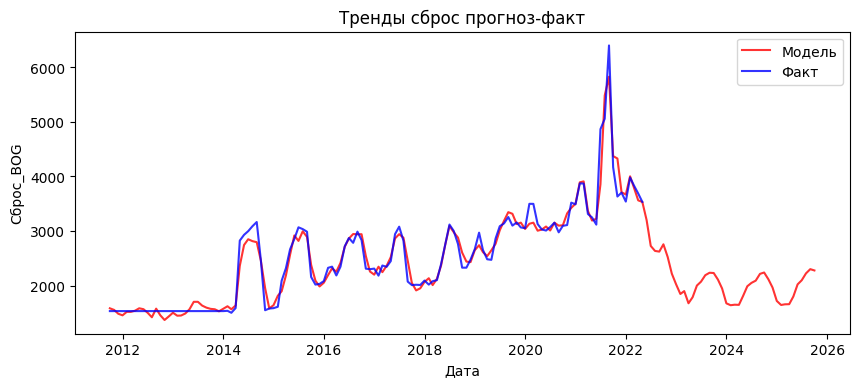

In [8]:
for col in GES_name:
    plt.subplots(figsize=(10,4), dpi=100);
    sns.lineplot(y=CatBoost_sbros[col].predict(scaler_sbros.transform(df_balance.loc[:, CatBoost_sbros[col].feature_names_])), x=df_balance.index,
                 label='Модель', color='Red', alpha=0.8);
    sns.lineplot(y=df_balance.loc[:coun, 'Сброс_'+col], x=df_balance.loc[:coun].index,
                 label='Факт', color='Blue', alpha=0.8);
    plt.title('Тренды сброс прогноз-факт');
    plt.savefig(f'../data/Результаты моделирования/Сброс прогноз/{current_date} Модель для {col}.png', dpi=200);
    plt.show();

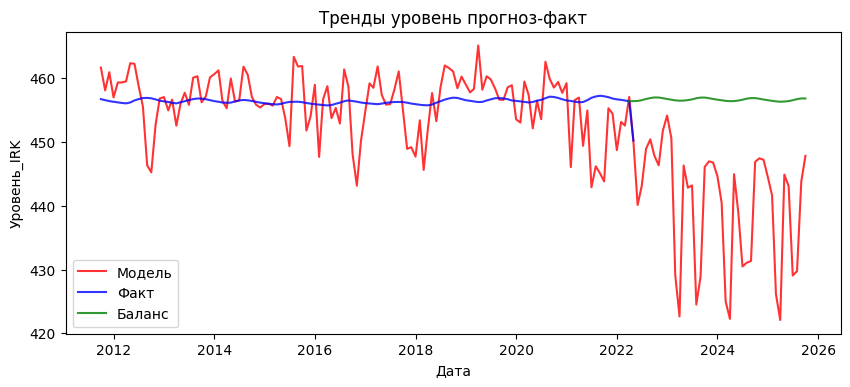

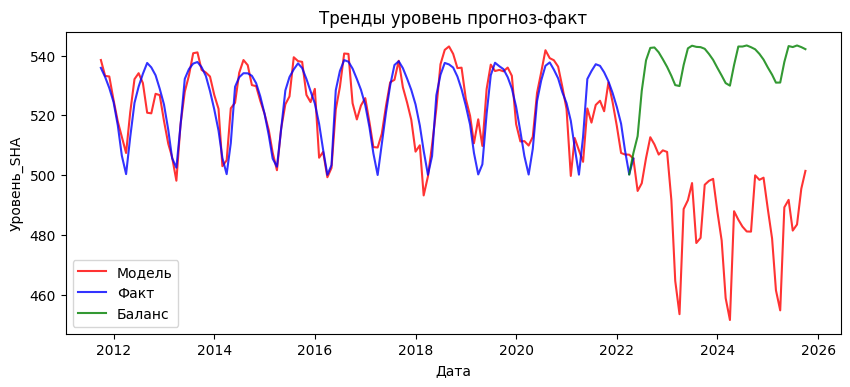

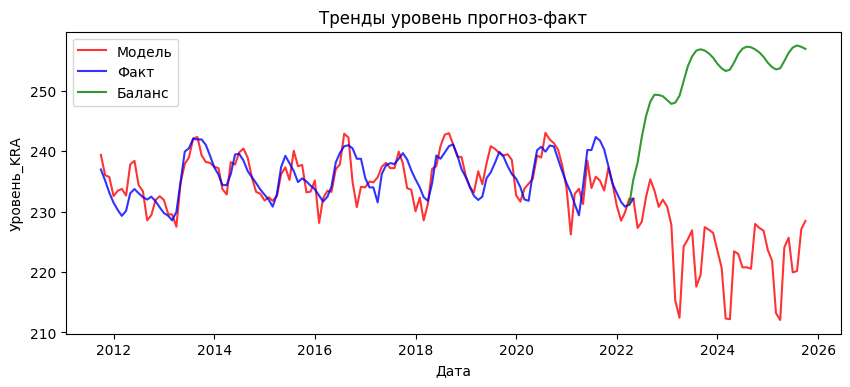

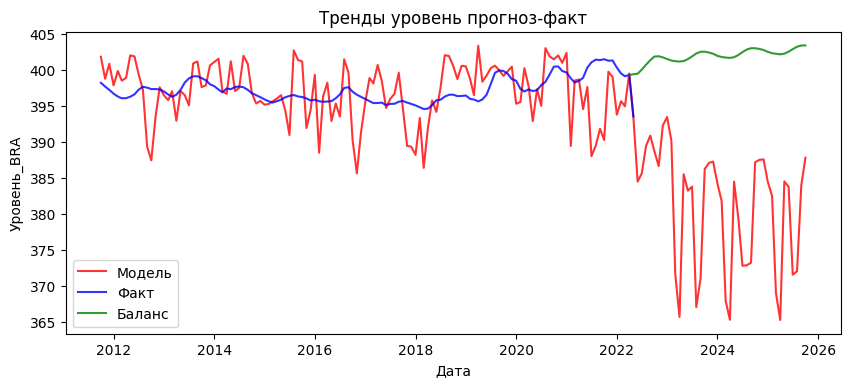

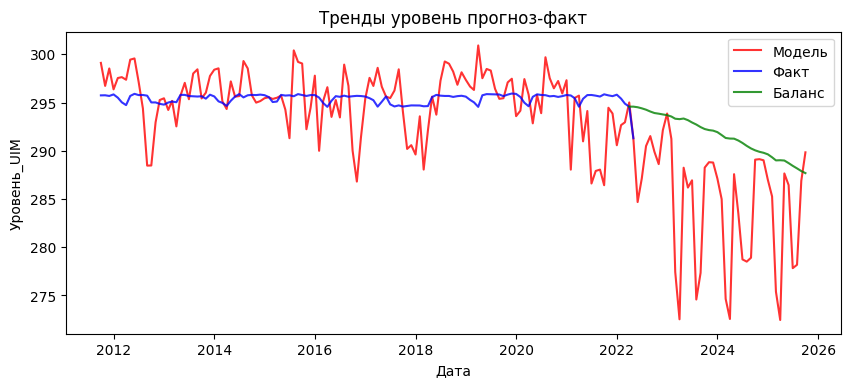

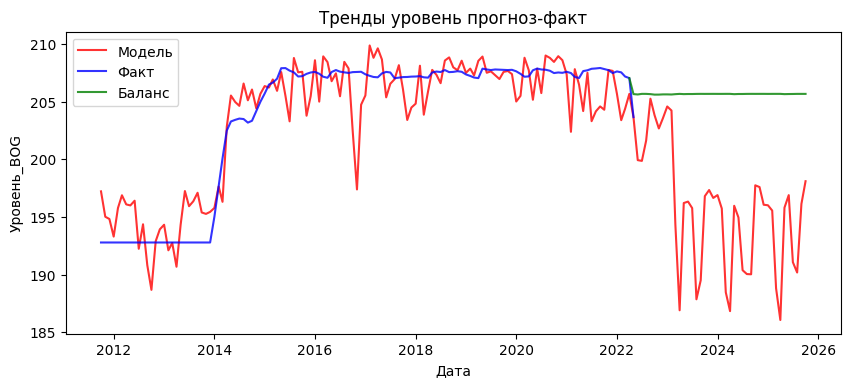

In [9]:
for col in GES_name:
    plt.subplots(figsize=(10,4), dpi=100);
    sns.lineplot(y=CatBoost_uroven[col].predict(scaler_uroven.transform(df_balance.loc[:, CatBoost_uroven[col].feature_names_])), x=df_balance.index,
                 label='Модель', color='Red', alpha=0.8);
    sns.lineplot(y=df_balance.loc[:coun, 'Уровень_'+col], x=df_balance.loc[:coun].index,
                 label='Факт', color='Blue', alpha=0.8);
    sns.lineplot(y=df_balance.loc[:, 'Баланс_Уровень_'+col], x=df_balance.index,
                 label='Баланс', color='Green', alpha=0.8);
    plt.title('Тренды уровень прогноз-факт');
    plt.savefig(f'../data/Результаты моделирования/Уровень прогноз/{current_date} Модель для {col}.png', dpi=200);
    plt.show();

# Сохраним результаты

In [10]:
#Для каждой ГЭС выберем лучший вариант пронгоза уровня
major_model = {'IRK': 'Баланс', 'SHA': 'Среднее', 'KRA': 'Уровень',
               'BRA': 'Среднее', 'UIM': 'Среднее', 'BOG': 'Баланс'};

#Заменим данные уровня Балансом или средним
for var in major_model:
    if major_model[var] == 'Среднее':
        df_balance.loc[coun:, 'Уровень_'+var] = (df_balance.loc[coun:, 'Баланс_Уровень_'+var] + df_balance.loc[coun:, 'Уровень_'+var]*1.1)/2;
    elif major_model[var] == 'Баланс':
        df_balance.loc[coun:, 'Уровень_'+var] = df_balance.loc[coun:, 'Баланс_Уровень_'+var];

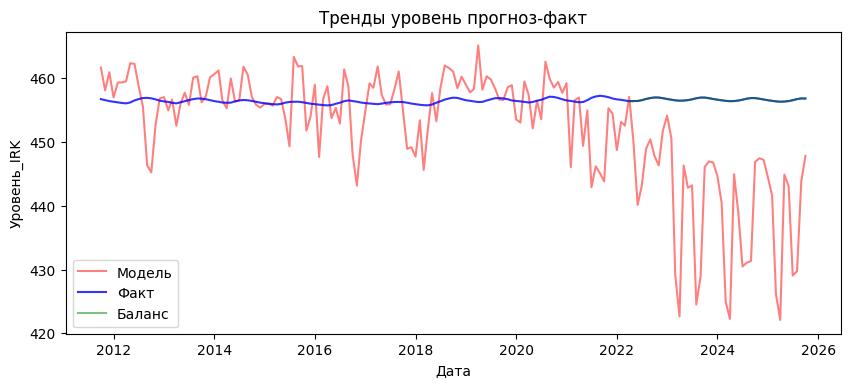

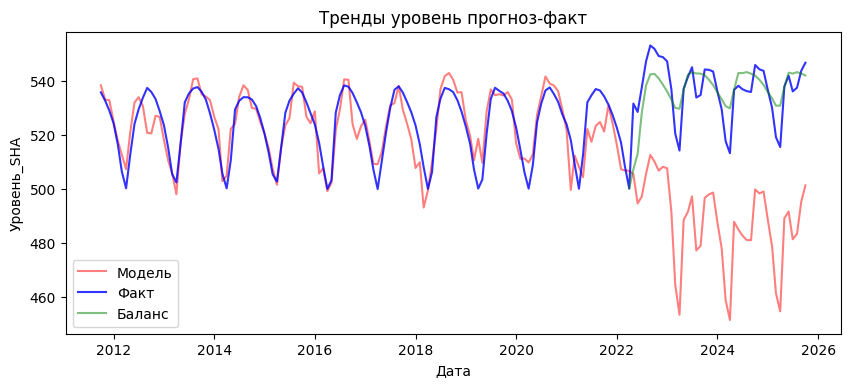

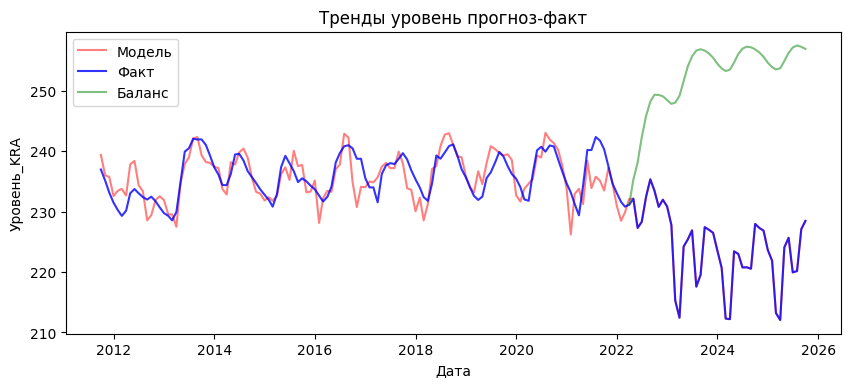

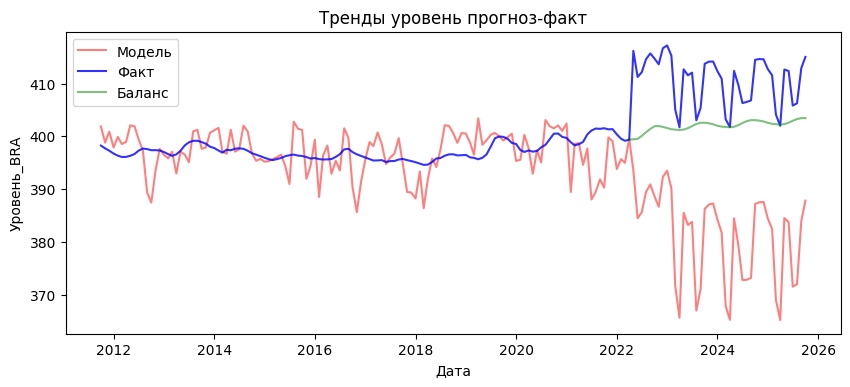

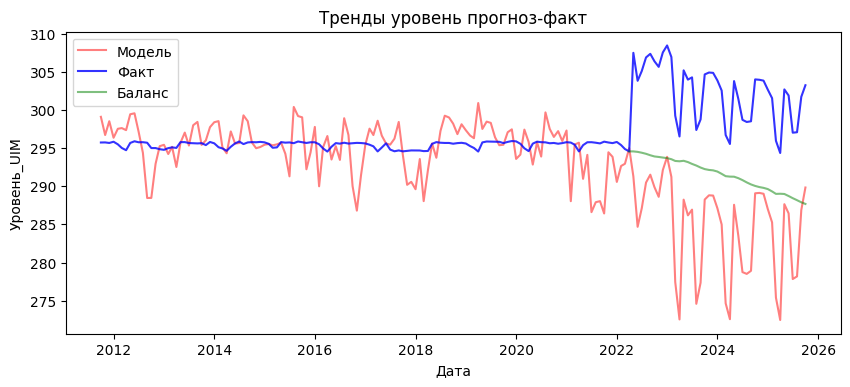

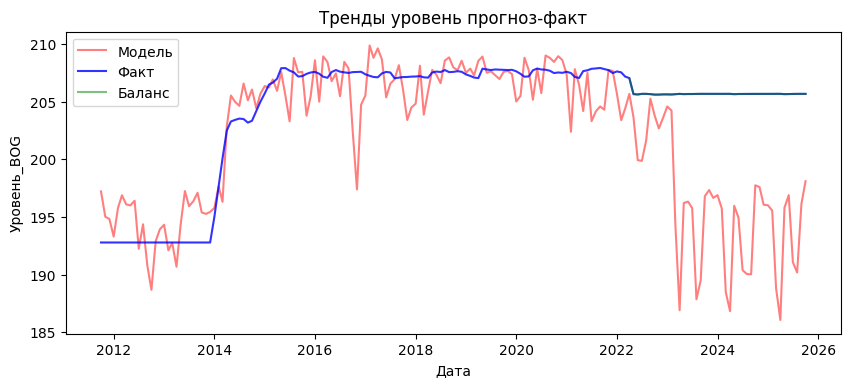

In [11]:
for col in GES_name:
    plt.subplots(figsize=(10,4), dpi=100);
    sns.lineplot(y=CatBoost_uroven[col].predict(scaler_uroven.transform(df_balance.loc[:, CatBoost_uroven[col].feature_names_])), x=df_balance.index,
                 label='Модель', color='Red', alpha=0.5);
    sns.lineplot(y=df_balance.loc[:, 'Уровень_'+col], x=df_balance.loc[:].index,
                 label='Факт', color='Blue', alpha=0.8);
    sns.lineplot(y=df_balance.loc[:, 'Баланс_Уровень_'+col], x=df_balance.index,
                 label='Баланс', color='Green', alpha=0.5);
    plt.title('Тренды уровень прогноз-факт');
    plt.show();

In [14]:
df_balance.drop(columns=[i for i in df_balance.columns if 'Sec_' in i or 'Баланс_' in i or 'Был_' in i]+['month', 'weekofyear']).to_excel(f'../data/Результаты моделирования/Выработка/{current_date} Прогноз метрик ГЭС.xlsx');
df_balance.drop(columns=[i for i in df_balance.columns if 'Sec_' in i or 'Баланс_' in i or 'Был_' in i]+['month', 'weekofyear'])

,Сброс_IRK,Сброс_SHA,Сброс_KRA,Сброс_BRA,Сброс_UIM,Сброс_BOG,Приток_IRK,Приток_SHA,Приток_KRA,Приток_BRA,Приток_UIM,Приток_BOG,Уровень_IRK,Уровень_SHA,Уровень_KRA,Уровень_BRA,Уровень_UIM,Уровень_BOG
Дата,,,,,,,,,,,,,,,,,,
2011-10-01,1500.000000,1142.000000,2751.000000,2825.000000,2807.000000,1531.000000,600.000000,1040.000000,2240.000000,2250.000000,2974.000000,2967.000000,456.700000,535.890000,236.990000,398.260000,295.740000,192.780000
2011-11-01,1500.000000,1100.000000,2639.000000,2806.000000,2844.000000,1531.000000,-300.000000,495.000000,1970.000000,1870.000000,2922.000000,2968.000000,456.550000,532.810000,235.150000,397.730000,295.750000,192.780000
2011-12-01,1500.000000,1064.000000,2616.000000,2695.000000,2799.000000,1531.000000,-300.000000,405.000000,1785.000000,1760.000000,2816.000000,2814.000000,456.390000,529.170000,233.150000,397.280000,295.680000,192.780000
2012-01-01,1500.000000,1175.000000,2456.000000,2776.000000,2748.000000,1531.000000,100.000000,390.000000,1740.000000,1710.000000,2933.000000,2908.000000,456.290000,524.440000,231.490000,396.750000,295.840000,192.780000
2012-02-01,1500.000000,1402.000000,2416.000000,2493.000000,2801.000000,1531.000000,290.000000,340.000000,1705.000000,1670.000000,2646.000000,2851.000000,456.200000,516.590000,230.260000,396.350000,295.500000,192.780000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01,1311.552200,926.661167,2404.050676,2215.215544,2372.179942,2032.596452,2219.357481,3386.881438,5649.816936,2734.272720,2215.215544,3295.713887,456.396744,542.048875,225.681091,412.372905,301.901886,205.659958
2025-07-01,1265.525737,938.856228,2481.273484,2337.379113,2495.855999,2108.682979,2863.333893,3690.763410,5714.781501,3039.074339,2337.379113,3266.538973,456.532571,536.234340,219.946728,405.826223,297.026602,205.664388
2025-08-01,1242.873381,949.045698,2464.812001,2346.660845,2492.804269,2251.888932,3252.331673,3020.083799,5437.423795,3016.752304,2346.660845,3242.367092,456.703403,537.620088,220.162188,406.256851,297.085854,205.672665
